In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

***Load the dataset***

In [2]:
df = pd.read_csv('datasets/egypt_tourist_locations.csv')
df.head()

,location_id,location_name,category,location,latitude,longitude,rating,user_id
0,1,Pyramids of Giza,Historical Landmark,Giza,29.9792,31.1342,4.5,1
1,2,Karnak Temple,Landmark,Luxor,25.7188,32.6573,4.6,1
2,3,Valley of the Kings,Historical Landmark,Luxor,25.7401,32.6012,4.7,1
3,4,Abu Simbel,Historical Landmark,Aswan,22.3375,31.6258,4.8,1
4,5,Muizz Street,Market,Cairo,30.0404,31.2494,4.4,1


***data properties***

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_id    50 non-null     int64  
 1   location_name  50 non-null     object 
 2   category       50 non-null     object 
 3   location       50 non-null     object 
 4   latitude       50 non-null     float64
 5   longitude      50 non-null     float64
 6   rating         50 non-null     float64
 7   user_id        50 non-null     int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 3.2+ KB


In [4]:
# df.location.value_counts()
df.category.value_counts()

Historical Landmark    17
Market                  5
Monastery               4
Beach                   4
Landmark                3
Museum                  3
Mosque                  3
Park                    2
Observation Deck        2
Hiking Trail            2
National Park           2
Garden                  1
Church                  1
Opera House             1
Name: category, dtype: int64

array([[<AxesSubplot:title={'center':'location_id'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'rating'}>],
       [<AxesSubplot:title={'center':'user_id'}>, <AxesSubplot:>]],
      dtype=object)

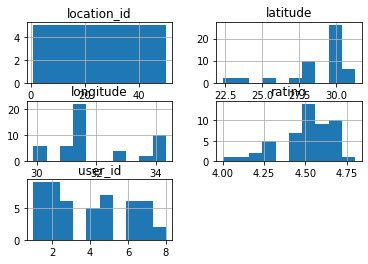

In [5]:
df.hist()

***convert the place category into vectors***

In [6]:
# Create a TF-IDF vectorizer to convert the place category into vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['category'])

***Compute pairwise cosine similarity between the place vectors***

In [7]:
cos_sim = cosine_similarity(X)

***Scale the ratings to be between 0 and 1***

In [8]:
scaler = MinMaxScaler()
df['scaled_rating'] = scaler.fit_transform(df['rating'].values.reshape(-1, 1))

In [9]:
df.head(5)

,location_id,location_name,category,location,latitude,longitude,rating,user_id,scaled_rating
0,1,Pyramids of Giza,Historical Landmark,Giza,29.9792,31.1342,4.5,1,0.625
1,2,Karnak Temple,Landmark,Luxor,25.7188,32.6573,4.6,1,0.750
2,3,Valley of the Kings,Historical Landmark,Luxor,25.7401,32.6012,4.7,1,0.875
3,4,Abu Simbel,Historical Landmark,Aswan,22.3375,31.6258,4.8,1,1.000
4,5,Muizz Street,Market,Cairo,30.0404,31.2494,4.4,1,0.500


***Fit a K-Means clustering model on the place vectors***

In [10]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

***Recommendation Function***

In [11]:
def recommend_trip(category: str, location: str, rating: float) -> dict:
    # Find the cluster corresponding to the user's category
    category_index = vectorizer.vocabulary_.get(category.lower())
    if category_index is None:
        return {'error': 'Invalid category'}

    category_cluster = kmeans.predict(X[cos_sim[category_index].argmax()])[0]
    cluster_mask = kmeans.labels_ == category_cluster

    # Filter the places in the same cluster as the user's category and within the user's location preferences
    location_mask = df['location'].str.contains(location, case=False)
    category_mask = df['category'].str.contains(category, case=False)
    filtered_places = df[location_mask & category_mask]

    if filtered_places.empty:
        return {'error': 'No places found in the given location and category'}
    
    try:
      # Filter the places with a rating less than or equal to the input rating
      rating_case = filtered_places['rating'] >= rating
      filtered_places = filtered_places[rating_case]
      # # Scale the rating to be between 0 and 1
      rating_scaled = scaler.transform([[float(rating)]])
      # # Compute the cosine similarity between the filtered places and the user's rating
      sim_scores = cosine_similarity(filtered_places['scaled_rating'].values.reshape(-1, 1), rating_scaled)
    except Exception as ex:
        return {'error': 'No places found in the given rating'}

    
    # Sort the places by similarity score and return the top recommendations
    top_indices = sim_scores.squeeze().argsort()[::-1][:10]
    top_places = filtered_places.iloc[top_indices]['location_name'].tolist()

    return top_places

In [13]:
recommend_trip(category='historical', location='Giza', rating=4.0)

['Sphinx',
 'Giza Necropolis',
 'Step Pyramid of Djoser',
 'Dahshur',
 'Saqqara',
 'Pyramids of Giza']